In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

In [6]:
from pathlib import Path
import pandas as pd

image_dir = Path('/Users/nijat/Downloads/split_data/')


filepaths = list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r"**/**/*.png"))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]

image_df = image_df.sample(frac=1).reset_index(drop=True)

image_df.head(50)


,Filepath,Label
0,/Users/nijat/Downloads/split_data/test/tubercu...,tuberculosis
1,/Users/nijat/Downloads/split_data/test/nodule/...,nodule
2,/Users/nijat/Downloads/split_data/train/pneumo...,pneumothorax
3,/Users/nijat/Downloads/split_data/train/covid/...,covid
4,/Users/nijat/Downloads/split_data/train/pneumo...,pneumothorax
5,/Users/nijat/Downloads/split_data/train/covid/...,covid
6,/Users/nijat/Downloads/split_data/train/contro...,control
7,/Users/nijat/Downloads/split_data/train/contro...,control
8,/Users/nijat/Downloads/split_data/train/mass/m...,mass
9,/Users/nijat/Downloads/split_data/train/pneumo...,pneumonia


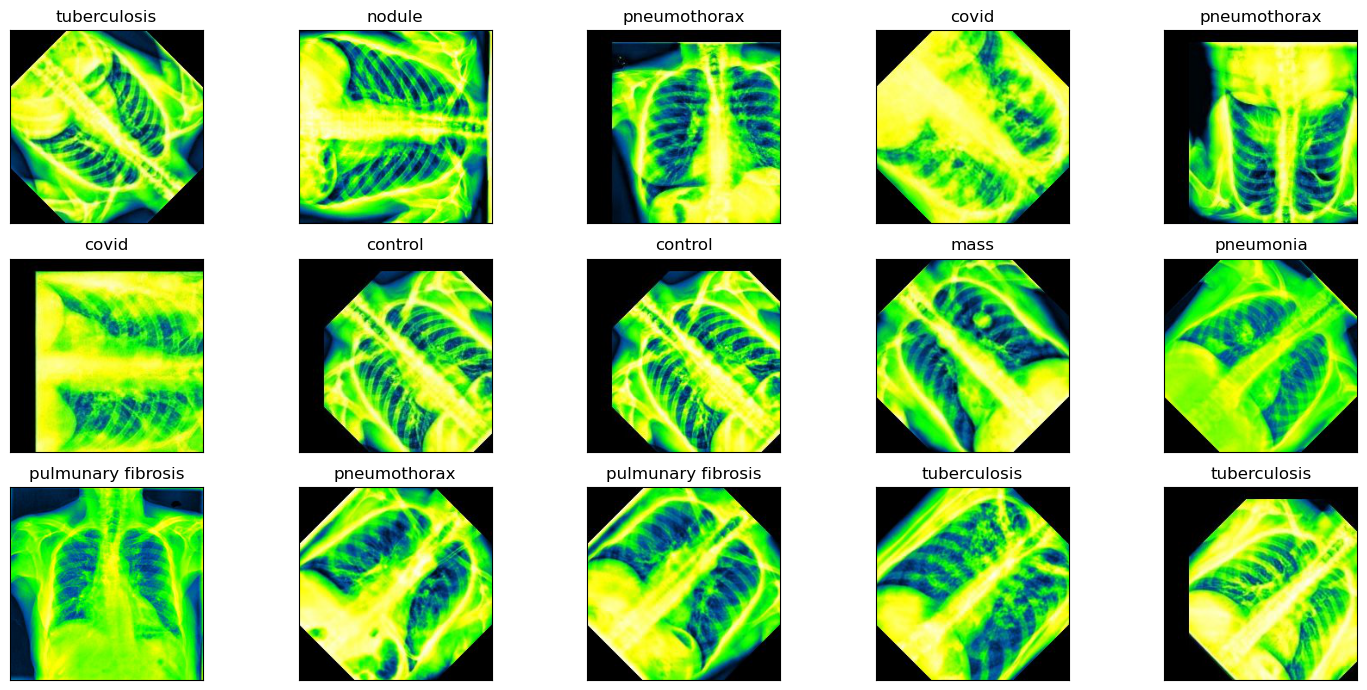

In [7]:

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                         subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [8]:
# Separate in train and test data
image_df['dataset'] = image_df['Filepath'].apply(lambda x: x.split('/')[-3])

train_df = image_df[image_df['dataset']=='train']
test_df = image_df[image_df['dataset']=='test']
print(train_df.shape, test_df.shape, image_df.shape)

(4056, 3) (1019, 3) (5075, 3)


In [9]:
# Configure GPU usage (Mac M2 specific)
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Ignore errors if no GPU is found
  pass

print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
#from sklearn.model_selection import train_test_split

#train_df, test_df = train_test_split(image_df, train_size=0.6, shuffle=True, random_state=1)

# Data generators
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
    validation_split=0.2
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224), 
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),  
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),  
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3245 validated image filenames belonging to 10 classes.
Found 811 validated image filenames belonging to 10 classes.
Found 1019 validated image filenames belonging to 10 classes.


In [11]:
pretrained_model = EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)  # Update input shape as required
    #pooling='avg'
)
pretrained_model.trainable = False
pretrained_model.summary()

2024-04-18 15:54:33.776656: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-04-18 15:54:33.776680: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-04-18 15:54:33.776690: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-04-18 15:54:33.776717: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-18 15:54:33.776732: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['normalizatio

In [12]:
#inputs = pretrained_model.input
#x = Flatten()(pretrained_model.output)
#outputs = Dense(10, activation='softmax')(x)
#model = Model(inputs=inputs, outputs=outputs)
#model.summary()

output = pretrained_model.output

# Apply the new Conv2d block to the output
x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='block6_conv1')(output)
x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='block6_conv2')(x)
x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='block6_conv3')(x)
x = tf.keras.layers.GlobalAveragePooling2D(name='block6_gap')(x)
x = tf.keras.layers.Flatten(name='block7_flatten')(x)
x = tf.keras.layers.Dense(10, activation='softmax')(x)

# Create a new model with the combined layers
model = tf.keras.Model(inputs=pretrained_model.input, outputs=x, name='LungNet22')
model.summary()

Model: "LungNet22"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['normalization[0][0]'

In [13]:
model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [14]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=300,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
)

Epoch 1/300


2024-04-18 15:56:33.723997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


102/102 [==============================] - ETA: 0s - loss: 1.7450 - accuracy: 0.4191

2024-04-18 15:56:44.936525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


102/102 [==============================] - 15s 87ms/step - loss: 1.7450 - accuracy: 0.4191 - val_loss: 1.2574 - val_accuracy: 0.5462
Epoch 2/300
102/102 [==============================] - 5s 49ms/step - loss: 0.9154 - accuracy: 0.6721 - val_loss: 0.7040 - val_accuracy: 0.7485
Epoch 3/300
102/102 [==============================] - 5s 50ms/step - loss: 0.6249 - accuracy: 0.7757 - val_loss: 0.5442 - val_accuracy: 0.7916
Epoch 4/300
102/102 [==============================] - 5s 50ms/step - loss: 0.4670 - accuracy: 0.8379 - val_loss: 0.5106 - val_accuracy: 0.8224
Epoch 5/300
102/102 [==============================] - 5s 50ms/step - loss: 0.3283 - accuracy: 0.8872 - val_loss: 0.4138 - val_accuracy: 0.8607
Epoch 6/300
102/102 [==============================] - 5s 50ms/step - loss: 0.2398 - accuracy: 0.9183 - val_loss: 0.4418 - val_accuracy: 0.8594
Epoch 7/300
102/102 [==============================] - 5s 51ms/step - loss: 0.2274 - accuracy: 0.9245 - val_loss: 0.2472 - val_accuracy: 0.9236
Epo

In [15]:
model.save('LungNet22_EfficientNetV2B0.keras')

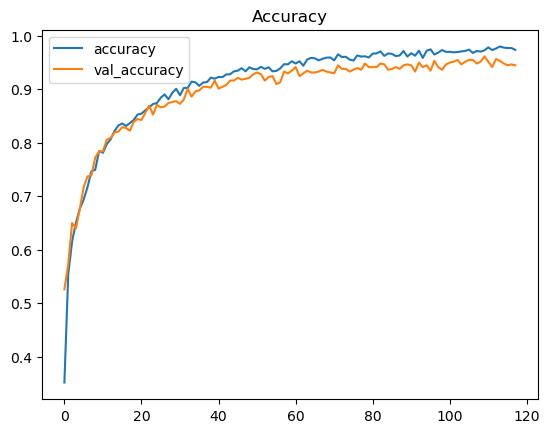

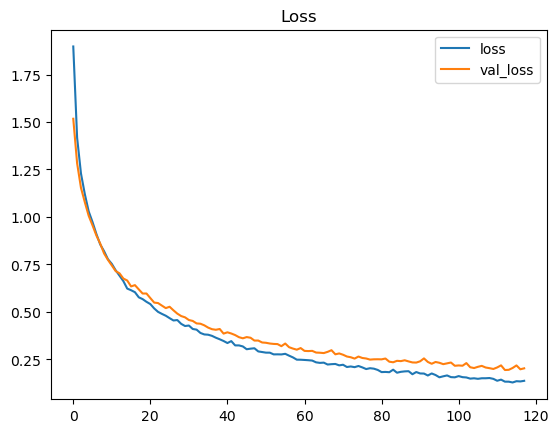

/opt/anaconda3/envs/mds2/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


    Test Loss: 0.22970
Test Accuracy: 94.28%


In [10]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy")
plt.show()


pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title("Loss")
plt.show()


results = model.evaluate(test_images, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))


In [11]:
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)
labels = (train_images.class_indices)
labels = dict((v, k) for k, v in labels.items())
pred = [labels[k] for k in pred]
print(f'The first 6 predictions: {pred[:6]}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 180ms/step
The first 6 predictions: ['lung Opacity', 'mass', 'covid', 'covid', 'mass', 'effusion']


                    precision    recall  f1-score   support

           control       0.98      1.00      0.99       201
             covid       1.00      0.98      0.99       206
          effusion       0.92      0.94      0.93       206
      lung Opacity       0.97      0.97      0.97       182
              mass       0.92      0.90      0.91       190
            nodule       0.90      0.89      0.90       207
         pneumonia       0.96      0.92      0.94       207
      pneumothorax       0.93      0.95      0.94       194
pulmunary fibrosis       0.87      0.92      0.89       204
      tuberculosis       0.99      0.95      0.97       195

          accuracy                           0.94      1992
         macro avg       0.94      0.94      0.94      1992
      weighted avg       0.94      0.94      0.94      1992



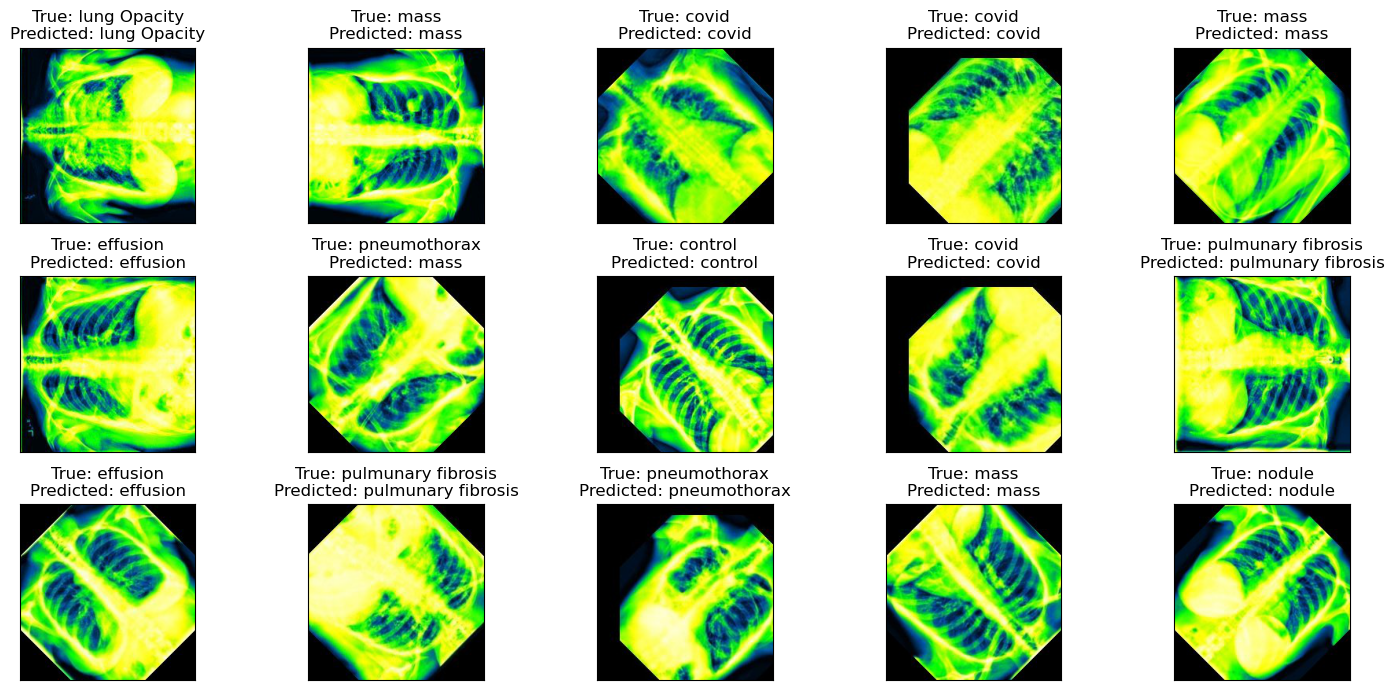

In [13]:
from sklearn.metrics import classification_report

y_test = list(test_df.Label)
print(classification_report(y_test, pred))

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                         subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()